I assume the following folder structure is already in place:<br>
[`working-directory`]<br>
– [`data`]<br>
– [`kaggle-data`]<br>
– – `train.csv`<br>
– – `test.csv`<br>
– [`models`]<br>
– [`submissions`]<br>
– `callbacks.py`<br>
– `datasets.py`<br>
– `generators.py`<br>
– `metrics.py`<br>
– `preprocessing.py`<br>
– `transformers.py`<br>

# Data Preprocessing

Here we call the `preprocess()` method of `preprocessing.py`, which generates the following files:<br>
[`working-directory`]<br>
– [`data`]<br>
– – `X_train.npy`<br>
– – `y_train.npy`<br>
– – `X_test.npy`

In [1]:
from preprocessing import preprocess

In [2]:
preprocess()

# Data Loading

Here we call the `load_data()` method of `datasets.py`, which generates training and test datasets. Datasets are dictionaries with "X" (train and test) and "y" (train only) keys storing the numpy array data.

In [3]:
from datasets import load_data

In [4]:
train, test = load_data()

# Denoising Autoencoder

## First Iteration (`dae1`)

Here we set up and train the autoencoder.

In [5]:
from models import AutoEncoder
import keras
from keras import backend as K
from keras import losses, optimizers
import numpy as np
from generators import swap_noise_generator
from callbacks import AutoEncoderCallback

Using TensorFlow backend.


In [6]:
K.clear_session()

Inputs are 221-dimensional, and so are outputs (we are trying to reconstruct the inputs). The hidden layers can have any dimensions, but here we use 3 fully-connected layers of 1500 nodes. The activation is defined in the topology ("r"=relu, "l"=linear, "s"=sigmoid). The swap rate defines the portion of data that will be swapped with inputs from another row to create noise in the dataset. The learning rate decays by (1-lr_decay) every epoch.

In [7]:
enc_config = {
    "topology": ["221", "1500r", "1500r", "1500r", "221l"],
    "batch_size": 128,
    "shuffle": True,
    "swap_rate": 0.07,
    "lr": 1e-4,
    "lr_decay": 0.95,
    "n_epochs": 50
}

In [8]:
enc = AutoEncoder(enc_config)

Our inputs and outputs are continuous (though some are binary and some are categorical), so we use mean-squared error as the loss function. Metrics are defined in the callback later, so here I set them to None.

In [9]:
enc.compile(loss=losses.mse, optimizer=optimizers.nadam(lr=enc_config["lr"]), metrics=None)

In [10]:
enc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 221)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              333000    
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_3 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_4 (Dense)              (None, 221)               331721    
Total params: 5,167,721
Trainable params: 5,167,721
Non-trainable params: 0
_________________________________________________________________


We can train the autoencoder on the full train+test dataset, since we don't need targets (this is unsupervised learning).

In [11]:
enc_data = {"X": np.concatenate([train["X"], test["X"]]).astype("float32")}

I use a simple 90/10 training/validation split.

In [12]:
enc_data_fit = {"X": enc_data["X"][:1340000]}
enc_data_val = {"X": enc_data["X"][1340000:]}

The callback will update the learning rate and print evaluation results as training progresses.

In [13]:
ae_callback = AutoEncoderCallback(enc_config, enc_data_fit, enc_data_val)

In [14]:
history = enc.fit_generator(
    generator=swap_noise_generator(enc_data_fit["X"], enc_config),
    steps_per_epoch=(len(enc_data_fit["X"]) // enc_config["batch_size"]),
    epochs=enc_config["n_epochs"],
    verbose=0,
    validation_data=swap_noise_generator(enc_data_val["X"], enc_config),
    validation_steps=(len(enc_data_val["X"]) // enc_config["batch_size"]),
    callbacks=[ae_callback]
)

EPOCH 0001/0050 | lr:0.000095 | TRAIN mse:0.00161 rmse:0.0402 mae:0.0221 | VALID mse:0.00161 rmse:0.0402 mae:0.0221 | 284.6s
EPOCH 0002/0050 | lr:0.000090 | TRAIN mse:0.00105 rmse:0.0323 mae:0.0154 | VALID mse:0.00105 rmse:0.0325 mae:0.0154 | 282.5s
EPOCH 0003/0050 | lr:0.000086 | TRAIN mse:0.00087 rmse:0.0295 mae:0.0133 | VALID mse:0.00088 rmse:0.0296 mae:0.0133 | 282.1s
EPOCH 0004/0050 | lr:0.000081 | TRAIN mse:0.00086 rmse:0.0293 mae:0.0122 | VALID mse:0.00087 rmse:0.0295 mae:0.0122 | 282.4s
EPOCH 0005/0050 | lr:0.000077 | TRAIN mse:0.00076 rmse:0.0276 mae:0.0111 | VALID mse:0.00077 rmse:0.0278 mae:0.0111 | 281.6s
EPOCH 0006/0050 | lr:0.000074 | TRAIN mse:0.00073 rmse:0.0269 mae:0.0104 | VALID mse:0.00074 rmse:0.0272 mae:0.0104 | 281.1s
EPOCH 0007/0050 | lr:0.000070 | TRAIN mse:0.00068 rmse:0.0261 mae:0.0099 | VALID mse:0.00069 rmse:0.0264 mae:0.0099 | 282.1s
EPOCH 0008/0050 | lr:0.000066 | TRAIN mse:0.00068 rmse:0.0261 mae:0.0092 | VALID mse:0.00069 rmse:0.0263 mae:0.0092 | 281.7s


In [15]:
enc.save_weights("models/enc001.h5")
enc.save_config("models/enc001.cfg")

# Multi-Layer Perceptron

## First Iteration (`mlp1`)

Here we set up and train the multi-layer perceptron.

In [16]:
from models import MultiLayerPerceptron
from keras import layers
from generators import mlp_generator
from callbacks import MultiLayerPerceptronCallback

Clearing the Keras session gets rid of unused tensors.

In [17]:
K.clear_session()

Inputs are 4500-dimensional (the concatenation of the 3 hidden layers in the autoencoder), while there is just one output (our estimated claim frequency). The hidden layers can have any dimensions, but here we use 2 fully-connected layers of 1000 nodes. We can also set the L2 regularization penalty (or set it to None for no regularization), and dropout for both inputs and hidden layers (again we can set these to None).

In [19]:
mlp_config = {
    "topology": ["4500", "1000r", "1000r", "1s"],
    "batch_size": 4096,
    "shuffle": True,
    "L2_reg": 0.01,
    "dropout": 0.2,
    "dropout_input": 0.1,
    "lr": 1e-4,
    "lr_decay": 0.95,
    "n_epochs": 50
}

Here we create the MLP by building the first layers of the autoencoder, setting their weights to those learned in the previous section, fixing those layers by setting trainable=False, adding a concatenation layer to concatenate autoencoder activations, and finally adding our fully connected layers.

In [20]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [21]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [22]:
mlp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 221)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1500)         333000      input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1500)         2251500     dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1500)         2251500     dense_2[0][0]                    
__________________________________________________________________________________________________
concatenat

Again a simple 90/10 training/validation split.

In [23]:
mlp_data_fit = {
    "X": train["X"][:536000],
    "y": train["y"][:536000]
}

mlp_data_val = {
    "X": train["X"][536000:],
    "y": train["y"][536000:]
}

This callback again updates the learning rate and shows evaluation results as training progresses.

In [24]:
mlp_callback = MultiLayerPerceptronCallback(mlp_config, mlp_data_fit, mlp_data_val)

In [25]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0050 | lr:0.000095 | TRAIN xent:0.1560 gini:0.1153 | VALID xent:0.1567 gini:0.1232 | 25.5s
EPOCH 0002/0050 | lr:0.000090 | TRAIN xent:0.1549 gini:0.1758 | VALID xent:0.1556 gini:0.1808 | 25.3s
EPOCH 0003/0050 | lr:0.000086 | TRAIN xent:0.1544 gini:0.2015 | VALID xent:0.1552 gini:0.2023 | 25.3s
EPOCH 0004/0050 | lr:0.000081 | TRAIN xent:0.1539 gini:0.2164 | VALID xent:0.1548 gini:0.2167 | 25.4s
EPOCH 0005/0050 | lr:0.000077 | TRAIN xent:0.1539 gini:0.2201 | VALID xent:0.1547 gini:0.2223 | 25.4s
EPOCH 0006/0050 | lr:0.000074 | TRAIN xent:0.1538 gini:0.2267 | VALID xent:0.1546 gini:0.2268 | 25.3s
EPOCH 0007/0050 | lr:0.000070 | TRAIN xent:0.1539 gini:0.2214 | VALID xent:0.1547 gini:0.2223 | 25.4s
EPOCH 0008/0050 | lr:0.000066 | TRAIN xent:0.1537 gini:0.2368 | VALID xent:0.1545 gini:0.2356 | 25.5s
EPOCH 0009/0050 | lr:0.000063 | TRAIN xent:0.1537 gini:0.2317 | VALID xent:0.1545 gini:0.2321 | 25.4s
EPOCH 0010/0050 | lr:0.000060 | TRAIN xent:0.1540 gini:0.2408 | VALID xent:0.1548 

Save the MLP weights and configuration (.cfg files are .json dictionaries):<br>
[`working-directory`]<br>
– [`models`]<br>
– – `mlp001.h5`<br>
– – `mlp001.cfg`

In [26]:
mlp.save_weights("models/mlp001.h5")
mlp.save_config("models/mlp001.cfg")

## Second Iteration (`mlp2`)

In [27]:
mlp_config = {
    "topology": ["4500", "1000r", "1000r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 0,
    "dropout": None,
    "dropout_input": None,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 20
}

In [28]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [29]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [30]:
mlp_callback = MultiLayerPerceptronCallback(mlp_config, mlp_data_fit, mlp_data_val, metrics=["xent", "gini"])

In [31]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0020 | lr:0.000990 | TRAIN loss:0.2075 xent:0.1652 gini:0.1404 | VALID loss:0.1634 xent:0.1660 gini:0.1447 | 18.2s
EPOCH 0002/0020 | lr:0.000980 | TRAIN loss:0.1564 xent:0.1528 gini:0.2521 | VALID loss:0.1509 xent:0.1537 gini:0.2466 | 18.1s
EPOCH 0003/0020 | lr:0.000970 | TRAIN loss:0.1553 xent:0.1546 gini:0.2671 | VALID loss:0.1534 xent:0.1554 gini:0.2607 | 18.2s
EPOCH 0004/0020 | lr:0.000961 | TRAIN loss:0.1532 xent:0.1552 gini:0.2766 | VALID loss:0.1562 xent:0.1561 gini:0.2683 | 18.2s
EPOCH 0005/0020 | lr:0.000951 | TRAIN loss:0.1537 xent:0.1643 gini:0.2586 | VALID loss:0.1667 xent:0.1653 gini:0.2588 | 18.3s
EPOCH 0006/0020 | lr:0.000941 | TRAIN loss:0.1538 xent:0.1516 gini:0.2831 | VALID loss:0.1573 xent:0.1528 gini:0.2724 | 18.3s
EPOCH 0007/0020 | lr:0.000932 | TRAIN loss:0.1529 xent:0.1543 gini:0.2865 | VALID loss:0.1552 xent:0.1555 gini:0.2761 | 18.3s
EPOCH 0008/0020 | lr:0.000923 | TRAIN loss:0.1534 xent:0.1514 gini:0.2900 | VALID loss:0.1550 xent:0.1526 gini:0.2768 

This model is our best performing, so we make test predictions and a submission DataFrame.

In [32]:
y_test = mlp.predict(test["X"])

In [33]:
import pandas as pd

In [34]:
test_id = pd.read_csv("kaggle-data/test.csv").id

In [35]:
submission_df = pd.concat([test_id, pd.Series(y_test.flatten(), name="target")], axis=1).set_index("id")

In [36]:
submission_df.head(20)

,target
id,
0,0.046255
1,0.038127
2,0.032908
3,0.019389
4,0.047219
5,0.061840
6,0.021402
7,0.052858
8,0.072725


Save the submission DataFrame to .csv format:<br>
[`working-directory`]<br>
– [`submissions`]<br>
– – `submission01.csv`

In [37]:
submission_df.to_csv("submissions/submission01.csv")

Save the MLP weights and configuration:<br>
[`working-directory`]<br>
– [`models`]<br>
– – `mlp002.h5`<br>
– – `mlp002.cfg`

In [38]:
mlp.save_weights("models/mlp002.h5")
mlp.save_config("models/mlp002.cfg")

## Third Iteration (`mlp3`)

In [39]:
mlp_config = {
    "topology": ["4500", "1000r", "1000r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 0.001,
    "dropout": 0.2,
    "dropout_input": 0.1,
    "lr": 1e-4,
    "lr_decay": 0.99,
    "n_epochs": 30
}

In [40]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [41]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [42]:
mlp_callback = MultiLayerPerceptronCallback(mlp_config, mlp_data_fit, mlp_data_val, metrics=["xent", "gini"])

In [43]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0030 | lr:0.000099 | TRAIN loss:2.6699 xent:0.1585 gini:-0.0079 | VALID loss:2.4559 xent:0.1591 gini:-0.0021 | 22.5s
EPOCH 0002/0030 | lr:0.000098 | TRAIN loss:2.2875 xent:0.1539 gini:0.2167 | VALID loss:2.1164 xent:0.1547 gini:0.2178 | 22.3s
EPOCH 0003/0030 | lr:0.000097 | TRAIN loss:1.9693 xent:0.1534 gini:0.2479 | VALID loss:1.8252 xent:0.1544 gini:0.2446 | 22.3s
EPOCH 0004/0030 | lr:0.000096 | TRAIN loss:1.7011 xent:0.1532 gini:0.2569 | VALID loss:1.5775 xent:0.1542 gini:0.2532 | 22.3s
EPOCH 0005/0030 | lr:0.000095 | TRAIN loss:1.4768 xent:0.1556 gini:0.2558 | VALID loss:1.3776 xent:0.1566 gini:0.2531 | 22.3s
EPOCH 0006/0030 | lr:0.000094 | TRAIN loss:1.2887 xent:0.1523 gini:0.2663 | VALID loss:1.1995 xent:0.1533 gini:0.2617 | 22.3s
EPOCH 0007/0030 | lr:0.000093 | TRAIN loss:1.1313 xent:0.1523 gini:0.2697 | VALID loss:1.0593 xent:0.1533 gini:0.2643 | 22.3s
EPOCH 0008/0030 | lr:0.000092 | TRAIN loss:1.0000 xent:0.1522 gini:0.2703 | VALID loss:0.9373 xent:0.1532 gini:0.265

## Fourth Iteration (`mlp4`)

In [44]:
mlp_config = {
    "topology": ["4500", "1000r", "1000r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 0.0001,
    "dropout": 0.1,
    "dropout_input": 0.01,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 30
}

In [45]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [46]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [47]:
mlp_callback = MultiLayerPerceptronCallback(mlp_config, mlp_data_fit, mlp_data_val, metrics=["xent", "gini"])

In [48]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0030 | lr:0.000990 | TRAIN loss:0.4129 xent:0.1572 gini:0.2123 | VALID loss:0.3198 xent:0.1580 gini:0.2122 | 22.5s
EPOCH 0002/0030 | lr:0.000980 | TRAIN loss:0.2983 xent:0.1536 gini:0.2414 | VALID loss:0.2764 xent:0.1545 gini:0.2390 | 22.3s
EPOCH 0003/0030 | lr:0.000970 | TRAIN loss:0.2660 xent:0.1535 gini:0.2648 | VALID loss:0.2527 xent:0.1544 gini:0.2595 | 22.3s
EPOCH 0004/0030 | lr:0.000961 | TRAIN loss:0.2480 xent:0.1534 gini:0.2621 | VALID loss:0.2393 xent:0.1543 gini:0.2587 | 22.3s
EPOCH 0005/0030 | lr:0.000951 | TRAIN loss:0.2327 xent:0.1537 gini:0.2669 | VALID loss:0.2262 xent:0.1547 gini:0.2634 | 22.3s
EPOCH 0006/0030 | lr:0.000941 | TRAIN loss:0.2222 xent:0.1530 gini:0.2702 | VALID loss:0.2169 xent:0.1540 gini:0.2668 | 22.3s
EPOCH 0007/0030 | lr:0.000932 | TRAIN loss:0.2120 xent:0.1524 gini:0.2765 | VALID loss:0.2073 xent:0.1533 gini:0.2707 | 22.3s
EPOCH 0008/0030 | lr:0.000923 | TRAIN loss:0.2065 xent:0.1558 gini:0.2768 | VALID loss:0.2038 xent:0.1566 gini:0.2714 

## Fifth Iteration (`mlp5`)

In [49]:
mlp_config = {
    "topology": ["4500", "1000r", "500r", "250r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 0,
    "dropout": None,
    "dropout_input": None,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 30
}

In [50]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [51]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [52]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0030 | lr:0.000990 | TRAIN loss:0.1854 xent:0.1639 gini:0.1733 | VALID loss:0.1633 xent:0.1648 gini:0.1742 | 19.2s
EPOCH 0002/0030 | lr:0.000980 | TRAIN loss:0.1566 xent:0.1550 gini:0.2482 | VALID loss:0.1602 xent:0.1559 gini:0.2435 | 17.0s
EPOCH 0003/0030 | lr:0.000970 | TRAIN loss:0.1552 xent:0.1560 gini:0.2637 | VALID loss:0.1553 xent:0.1571 gini:0.2581 | 17.0s
EPOCH 0004/0030 | lr:0.000961 | TRAIN loss:0.1543 xent:0.1541 gini:0.2738 | VALID loss:0.1556 xent:0.1552 gini:0.2666 | 17.0s
EPOCH 0005/0030 | lr:0.000951 | TRAIN loss:0.1544 xent:0.1524 gini:0.2796 | VALID loss:0.1542 xent:0.1535 gini:0.2705 | 17.1s
EPOCH 0006/0030 | lr:0.000941 | TRAIN loss:0.1543 xent:0.1552 gini:0.2828 | VALID loss:0.1547 xent:0.1561 gini:0.2732 | 16.9s
EPOCH 0007/0030 | lr:0.000932 | TRAIN loss:0.1534 xent:0.1522 gini:0.2863 | VALID loss:0.1534 xent:0.1533 gini:0.2746 | 17.0s
EPOCH 0008/0030 | lr:0.000923 | TRAIN loss:0.1534 xent:0.1543 gini:0.2891 | VALID loss:0.1568 xent:0.1554 gini:0.2767 

## Sixth Iteration (`mlp6`)

In [53]:
mlp_config = {
    "topology": ["4500", "1000r", "500r", "250r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 1e-4,
    "dropout": 0.1,
    "dropout_input": None,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 30
}

In [54]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [55]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [56]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0030 | lr:0.000990 | TRAIN loss:0.3970 xent:0.1554 gini:0.1550 | VALID loss:0.3172 xent:0.1562 gini:0.1575 | 20.7s
EPOCH 0002/0030 | lr:0.000980 | TRAIN loss:0.2968 xent:0.1571 gini:0.2259 | VALID loss:0.2789 xent:0.1581 gini:0.2241 | 18.6s
EPOCH 0003/0030 | lr:0.000970 | TRAIN loss:0.2656 xent:0.1533 gini:0.2448 | VALID loss:0.2497 xent:0.1541 gini:0.2446 | 18.7s
EPOCH 0004/0030 | lr:0.000961 | TRAIN loss:0.2450 xent:0.1553 gini:0.2632 | VALID loss:0.2361 xent:0.1562 gini:0.2593 | 18.7s
EPOCH 0005/0030 | lr:0.000951 | TRAIN loss:0.2310 xent:0.1577 gini:0.2681 | VALID loss:0.2280 xent:0.1585 gini:0.2634 | 18.6s
EPOCH 0006/0030 | lr:0.000941 | TRAIN loss:0.2211 xent:0.1601 gini:0.2700 | VALID loss:0.2228 xent:0.1609 gini:0.2646 | 18.7s
EPOCH 0007/0030 | lr:0.000932 | TRAIN loss:0.2114 xent:0.1534 gini:0.2693 | VALID loss:0.2080 xent:0.1543 gini:0.2660 | 18.7s
EPOCH 0008/0030 | lr:0.000923 | TRAIN loss:0.2059 xent:0.1523 gini:0.2713 | VALID loss:0.1985 xent:0.1533 gini:0.2671 

## Seventh Iteration (`mlp7`)

In [57]:
mlp_config = {
    "topology": ["4500", "1000r", "500r", "250r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 1e-8,
    "dropout": 0.1,
    "dropout_input": None,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 30
}

In [58]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [59]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [60]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0030 | lr:0.000990 | TRAIN loss:0.1945 xent:0.1629 gini:0.1927 | VALID loss:0.1644 xent:0.1636 gini:0.1941 | 18.9s
EPOCH 0002/0030 | lr:0.000980 | TRAIN loss:0.1587 xent:0.1589 gini:0.2509 | VALID loss:0.1612 xent:0.1597 gini:0.2459 | 18.7s
EPOCH 0003/0030 | lr:0.000970 | TRAIN loss:0.1568 xent:0.1535 gini:0.2642 | VALID loss:0.1559 xent:0.1544 gini:0.2595 | 18.6s
EPOCH 0004/0030 | lr:0.000961 | TRAIN loss:0.1562 xent:0.1527 gini:0.2716 | VALID loss:0.1546 xent:0.1536 gini:0.2649 | 18.7s
EPOCH 0005/0030 | lr:0.000951 | TRAIN loss:0.1555 xent:0.1602 gini:0.2768 | VALID loss:0.1643 xent:0.1610 gini:0.2705 | 18.7s
EPOCH 0006/0030 | lr:0.000941 | TRAIN loss:0.1555 xent:0.1522 gini:0.2775 | VALID loss:0.1583 xent:0.1532 gini:0.2724 | 18.7s
EPOCH 0007/0030 | lr:0.000932 | TRAIN loss:0.1535 xent:0.1519 gini:0.2832 | VALID loss:0.1536 xent:0.1529 gini:0.2739 | 18.7s
EPOCH 0008/0030 | lr:0.000923 | TRAIN loss:0.1564 xent:0.1528 gini:0.2840 | VALID loss:0.1555 xent:0.1538 gini:0.2746 

## Eighth Iteration (`mlp8`)

In [61]:
mlp_config = {
    "topology": ["4500", "1000r", "500r", "250r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 0,
    "dropout": 0.5,
    "dropout_input": None,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 30
}

In [62]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")

In [63]:
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)

In [64]:
mlp_history = mlp.fit_generator(
    generator=mlp_generator(mlp_data_fit["X"], mlp_data_fit["y"], mlp_config["batch_size"]),
    steps_per_epoch=(len(mlp_data_fit["X"]) // mlp_config["batch_size"]),
    epochs=mlp_config["n_epochs"],
    verbose=0,
    validation_data=mlp_generator(mlp_data_val["X"], mlp_data_val["y"], mlp_config["batch_size"]),
    validation_steps=(len(mlp_data_val["X"]) // mlp_config["batch_size"]),
    callbacks=[mlp_callback]
)

EPOCH 0001/0030 | lr:0.000990 | TRAIN loss:0.2029 xent:0.1828 gini:0.2221 | VALID loss:0.1843 xent:0.1834 gini:0.2241 | 18.7s
EPOCH 0002/0030 | lr:0.000980 | TRAIN loss:0.1663 xent:0.1649 gini:0.2512 | VALID loss:0.1662 xent:0.1657 gini:0.2495 | 18.5s
EPOCH 0003/0030 | lr:0.000970 | TRAIN loss:0.1639 xent:0.1561 gini:0.2633 | VALID loss:0.1584 xent:0.1569 gini:0.2597 | 18.6s
EPOCH 0004/0030 | lr:0.000961 | TRAIN loss:0.1633 xent:0.1839 gini:0.2704 | VALID loss:0.1849 xent:0.1847 gini:0.2637 | 18.6s
EPOCH 0005/0030 | lr:0.000951 | TRAIN loss:0.1624 xent:0.1847 gini:0.2740 | VALID loss:0.1851 xent:0.1854 gini:0.2672 | 18.6s
EPOCH 0006/0030 | lr:0.000941 | TRAIN loss:0.1609 xent:0.2521 gini:0.2772 | VALID loss:0.2534 xent:0.2527 gini:0.2700 | 18.6s
EPOCH 0007/0030 | lr:0.000932 | TRAIN loss:0.1606 xent:0.2226 gini:0.2791 | VALID loss:0.2223 xent:0.2233 gini:0.2697 | 18.6s
EPOCH 0008/0030 | lr:0.000923 | TRAIN loss:0.1591 xent:0.1781 gini:0.2804 | VALID loss:0.1812 xent:0.1789 gini:0.2700 

## Load Best Iteration (`mlp2`)

In [65]:
mlp_config = {
    "topology": ["4500", "1000r", "1000r", "1s"],
    "batch_size": 16384,
    "shuffle": True,
    "L2_reg": 0,
    "dropout": None,
    "dropout_input": None,
    "lr": 1e-3,
    "lr_decay": 0.99,
    "n_epochs": 20
}

In [66]:
mlp = MultiLayerPerceptron(mlp_config, enc_config="models/enc001.cfg", enc_weights="models/enc001.h5")
mlp.compile(loss=losses.binary_crossentropy, optimizer=optimizers.nadam(lr=mlp_config["lr"]), metrics=None)
mlp.load_weights("models/mlp002.h5")

## Activation Model

In [67]:
m = keras.models.Model(mlp.input, [mlp.input, mlp.layers[-4].output, mlp.layers[-3].output, mlp.layers[-2].output, mlp.output])

In [68]:
m_pred = m.predict(train["X"])

## Visualization

Here we create a visualization of the target and predicted values for each observation, scattered over the 2D principal components space of:
- inputs
- DAE encodings
- MLP first layer activations
- MLP second layer activations

In [72]:
import matplotlib
import matplotlib.pyplot as plt

# Important to use IncrementalPCA unless you have a very substantial amount of RAM
from sklearn.decomposition import IncrementalPCA

In [70]:
y_pred = m_pred[-1].flatten()

C:\Program Files\Anaconda3\envs\py35\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


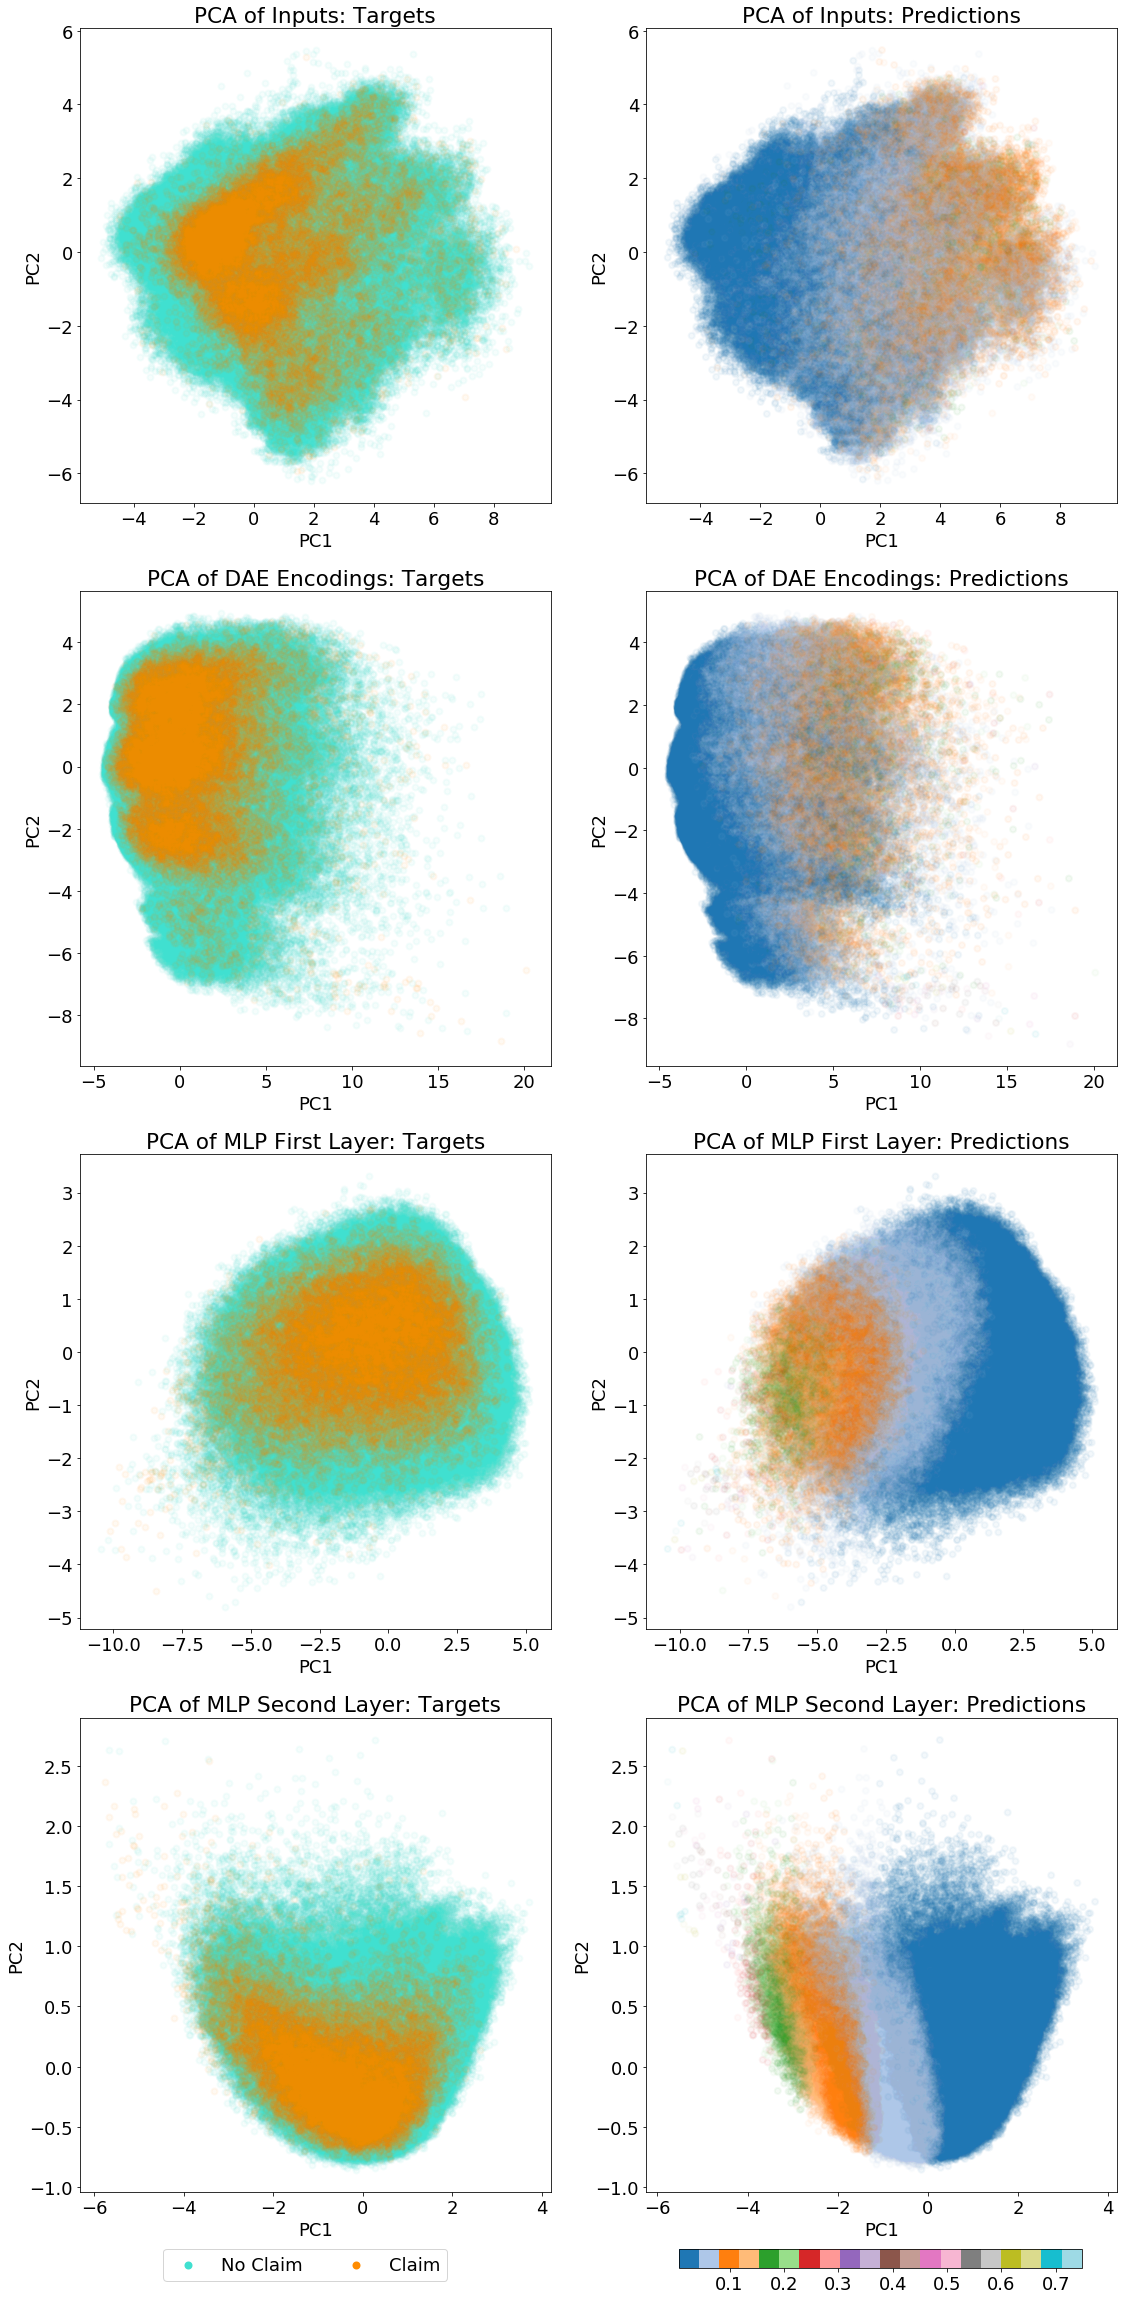

In [71]:
matplotlib.rcParams.update({"font.size": 18})

fig, axs = plt.subplots(4, 2, figsize=(16, 32))

plot_titles = [
    "PCA of Inputs",
    "PCA of DAE Encodings",
    "PCA of MLP First Layer",
    "PCA of MLP Second Layer"
]

for l in range(4):
    L_pred = m_pred[l]
    
    pca = IncrementalPCA(2, batch_size=1024)
    L_pc = pca.fit_transform(L_pred)

    ax = axs[l, 0]
    colors = ["turquoise", "darkorange"]
    y = train["y"]
    for color, i, target_name in zip(colors, [0, 1], ["No Claim", "Claim"]):
        ax.scatter(
            L_pc[y == i, 0], L_pc[y == i, 1],
            color=color, label=target_name,
            alpha=0.05, lw=2
        )

        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_title("{:s}: {:s}".format(plot_titles[l], "Targets"))
        
    ax = axs[l, 1]
    im = ax.scatter(
        L_pc[:, 0], L_pc[:, 1],
        c=y_pred,
        cmap=plt.get_cmap("tab20"),
        alpha=0.05, lw=2
    )

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("{:s}: {:s}".format(plot_titles[l], "Predictions"))

leg = axs[-1, 0].legend(bbox_to_anchor=(0.8, -0.1), ncol=2)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

cax = fig.add_axes([0.6, 0.01, 0.35, 0.008]) 
cb = fig.colorbar(im, ax=axs[-1, 1], cax=cax, orientation="horizontal")
cb.solids.set(alpha=1)

plt.tight_layout()
plt.show()